In [1]:
import sys
import collections
import numpy as np
from scipy.stats import norm, expon, erlang, gamma

%matplotlib inline
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt

sys.path.append('..')
from higgs_inference.various.utils import r_from_s, s_from_r, format_number

# Toy model

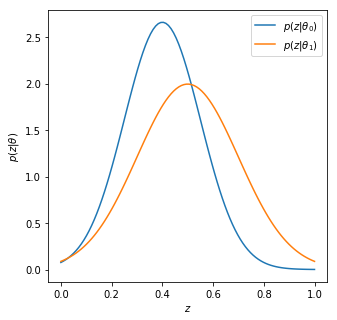

In [2]:
p_z_theta0 = norm(loc=0.4,scale=0.15)
p_z_theta1 = norm(loc=0.5,scale=0.2)

plt.figure(figsize=(5,5))
z = np.linspace(0.,1.,100)
plt.plot(z, p_z_theta0.pdf(z), label=r'$p(z | \theta_0)$')
plt.plot(z, p_z_theta1.pdf(z), label=r'$p(z | \theta_1)$')
plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'$p(z | \theta)$')
plt.show()

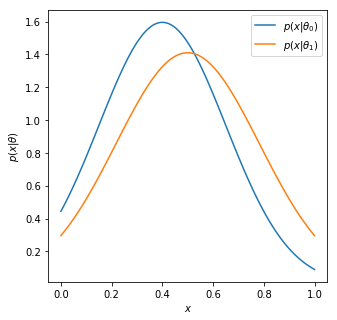

In [3]:
def p_x_z(z):
    return norm(loc=z, scale=0.2)

p_x_theta0 = norm(loc=0.4,scale=(0.15**2 + 0.2**2)**0.5)
p_x_theta1 = norm(loc=0.5,scale=(0.2**2 + 0.2**2)**0.5)

plt.figure(figsize=(5,5))
x = np.linspace(0.,1.,100)
plt.plot(x, p_x_theta0.pdf(x), label=r'$p(x | \theta_0)$')
plt.plot(x, p_x_theta1.pdf(x), label=r'$p(x | \theta_1)$')
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$p(x | \theta)$')
plt.show()

In [4]:
def p_xz(x,z):
    return 0.5 * (p_z_theta0.pdf(z) + p_z_theta1.pdf(z)) * p_x_z(z).pdf(x)

def p_z_x(z,x):
    num = p_x_z(z).pdf(x) * 0.5 * (p_z_theta0.pdf(z) + p_z_theta0.pdf(z))
    den = 0.5 * (p_x_theta0.pdf(x) + p_x_theta1.pdf(x))
    return num / den

def sample_from_p_z_x(x, n, theta='both', factor=3.):
    all_z = []
    
    while len(all_z) < n:
        draws = int(n-len(all_z))
        if theta==0:
            z = p_z_theta0.rvs(draws)
            p_keep = p_x_z(z).pdf(x) / p_x_theta0.pdf(x) / factor
        elif theta==1:
            z = p_z_theta0.rvs(draws)
            p_keep = p_x_z(z).pdf(x) / p_x_theta1.pdf(x) / factor
        elif theta=='both':
            draws_first = draws // 2
            if np.random.rand() < 0.5:
                z = np.hstack([p_z_theta0.rvs(draws_first),
                               p_z_theta1.rvs(draws - draws_first)])
            else:
                z = np.hstack([p_z_theta1.rvs(draws_first),
                               p_z_theta0.rvs(draws - draws_first)])
                
            p_keep = p_x_z(z).pdf(x) / (0.5 * p_x_theta0.pdf(x) + 0.5 * p_x_theta1.pdf(x)) / factor
            
        else:
            raise ValueError(theta)
            
        dice = np.random.rand(*(p_keep.shape))
        if np.any(p_keep > 1.):
            print('Warning: p > 1 in rejection algorithm: ', np.sum(p_keep > 1.))
        
        all_z += list(z[dice < p_keep])
            
    all_z = np.array(all_z)
    np.random.shuffle(all_z)
    return all_z

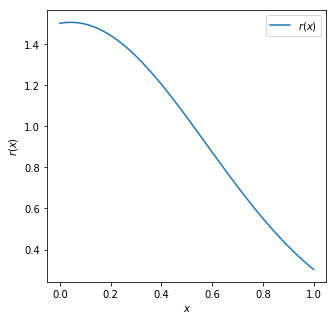

In [5]:
def r_x(x):
    return p_x_theta0.pdf(x) / p_x_theta1.pdf(x)

def r_xz(x,z):
    _r_xz = (p_z_theta0.pdf(z) * p_x_z(z).pdf(x)) / (p_z_theta1.pdf(z) * p_x_z(z).pdf(x))
    return np.clip(_r_xz, np.exp(-10.), np.exp(10.))

plt.figure(figsize=(5,5))
x = np.linspace(0.,1.,100)
plt.plot(x, r_x(x), label=r'$r(x)$')
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$r(x)$')
plt.show()

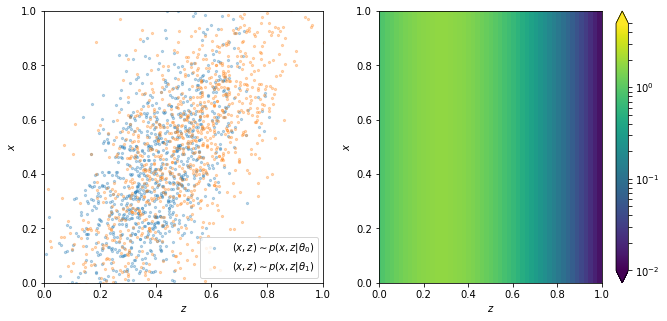

In [6]:
z_from_theta0 = p_z_theta0.rvs(1000)
x_from_theta0 = p_x_z(z_from_theta0).rvs(1000)

z_from_theta1 = p_z_theta1.rvs(1000)
x_from_theta1 = p_x_z(z_from_theta1).rvs(1000)

fig = plt.figure(figsize=(11,5))

ax = plt.subplot(1,2,1)
plt.scatter(z_from_theta0, x_from_theta0, alpha=0.3, s=5, label=r'$(x,z) \sim p(x, z | \theta_0)$')
plt.scatter(z_from_theta1, x_from_theta1, alpha=0.3, s=5, label=r'$(x,z) \sim p(x, z | \theta_1)$')
plt.legend(loc='lower right')
plt.xlim(0.,1.)
plt.ylim(0.,1.)
plt.xlabel(r'$z$')
plt.ylabel(r'$x$')

ax = plt.subplot(1,2,2)
xi = np.linspace(-1.0, 1.0, 100)
zi = np.linspace(-1.0, 1.0, 100)
zz, xx = np.meshgrid(xi, zi)
pcm = ax.pcolormesh(zi, xi, r_xz(xx, zz).reshape((100, 100)),
                   norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=5.),
                   cmap='viridis')
cbar = fig.colorbar(pcm, ax=ax, extend='both')
plt.xlim(0.,1.)
plt.ylim(0.,1.)
plt.xlabel(r'$z$')
plt.ylabel(r'$x$')

plt.show()

# Loss functions (with large statistics)

In [7]:
def mse(r, x, zmin=-10., zmax=11., zsteps=2100):
    z_integration = np.linspace(zmin, zmax, zsteps)
    dz_integration = (zmax - zmin) / zsteps
    
    p_integrands_1 = p_z_theta1.pdf(z_integration) * p_x_z(z_integration).pdf(x)
    mse_integrands_1 = (r - r_xz(x, z_integration))**2
    
    p_integrands_0 = p_z_theta0.pdf(z_integration) * p_x_z(z_integration).pdf(x)
    mse_integrands_0 = (1./r - 1./r_xz(x, z_integration))**2
    
    integrands = (
        dz_integration
        * (p_integrands_1 * mse_integrands_1 + p_integrands_0 * mse_integrands_0)
    )
    
    mse = np.sum(integrands[np.isfinite(integrands)])
    
    return mse

In [8]:
def xe(r, x, zmin=-10., zmax=11., zsteps=2100):
    s_hat_x = s_from_r(r)
    
    z_integration = np.linspace(zmin, zmax, zsteps)
    dz_integration = (zmax - zmin) / zsteps
    p_integrands = p_xz(x,z_integration)
    
    r_xz_integrands = r_xz(x, z_integration)
    s_xz_integrands = s_from_r(r_xz_integrands)
    xe_integrands = s_xz_integrands * np.log(s_hat_x) + (1. - s_xz_integrands) * np.log(1. - s_hat_x)
    
    integrands = (
        dz_integration
        * p_integrands
        * xe_integrands
    )
    
    xe = - np.sum(integrands[np.isfinite(integrands)])
    
    return xe
    

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


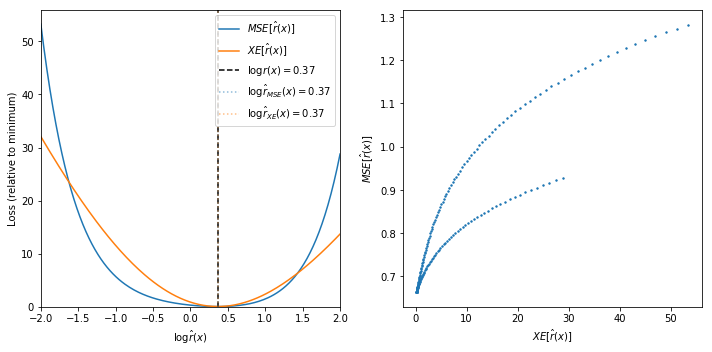

In [10]:
x = 0.2
logr_min=-2.
logr_max=2.
logr_steps=200

logr_test = np.linspace(logr_min, logr_max, logr_steps)
r_test = np.exp(logr_test)
mse_test = np.array([mse(r_, x) for r_ in r_test])
xe_test = np.array([xe(r_, x) for r_ in r_test])

logr_true = np.log(r_x(x))
logrhat_mse = np.log(r_test[np.argmin(mse_test)])
logrhat_xe = np.log(r_test[np.argmin(xe_test)])

rescaling = np.mean(mse_test - np.min(mse_test)) / np.mean((xe_test - np.min(xe_test)))

fig = plt.figure(figsize=(10,5))

ax = plt.subplot(1,2,1)

plt.plot(logr_test, mse_test - np.min(mse_test), c='C0', label=r'$MSE[\hat{r}(x)]$')
plt.plot(logr_test, rescaling * (xe_test - np.min(xe_test)), c='C1', label=r'$XE[\hat{r}(x)]$')

plt.axvline(logr_true, c='black', ls='--', label=r'$\log  r(x) = ' + format_number(logr_true,2) + '$')
plt.axvline(logrhat_mse, c='C0', alpha=0.5, ls=':', label=r'$\log  \hat{r}_{MSE}(x) = ' + format_number(logrhat_mse,2) + '$')
plt.axvline(logrhat_xe, c='C1', alpha=0.5, ls=':', label=r'$\log  \hat{r}_{XE}(x) = ' + format_number(logrhat_xe,2) + '$')

plt.legend(loc='upper right')
plt.xlim(logr_min, logr_max)
plt.ylim(0.,None)
plt.ylabel(r'Loss (relative to minimum)')
plt.xlabel(r'$\log \hat{r}(x)$')

ax = plt.subplot(1,2,2)

plt.scatter(mse_test, xe_test, c='C0', s=2)

plt.ylabel(r'$MSE[\hat{r}(x)]$')
plt.xlabel(r'$XE[\hat{r}(x)]$')

plt.tight_layout()
plt.show()

# Loss functions (with limited samples)

In [60]:
def mse_sampled(r_hats, x, n_samples=10, n_trials=10000):
    n_r = len(r_hats)
    
    r = np.empty((n_samples*n_trials, n_r))
    r[:,:] = r_hats
    r = r.T
    
    z_samples = sample_from_p_z_x(x=x, n=n_samples*n_trials, theta=1)
    z = np.empty(r.shape)
    z[:,:] = z_samples
    
    x_in = x
    x = np.empty(r.shape)
    x[:,:] = x_in
    
    mse_integrands = (r - r_xz(x, z))**2
    mse_integrands = mse_integrands.reshape((n_r, n_trials, n_samples))
    
    mses = 1./n_samples * np.sum(mse_integrands, axis=2)
         
    return np.mean(mses, axis=1), np.std(mses, axis=1)


In [61]:
def mse_inverse_sampled(r_hats, x, n_samples=10, n_trials=10000):
    n_r = len(r_hats)
    
    r = np.empty((n_samples*n_trials//2, n_r))
    r[:,:] = r_hats
    r = r.T
    
    z_samples = sample_from_p_z_x(x=x, n=n_samples*n_trials//2, theta=1)
    z = np.empty(r.shape)
    z[:,:] = z_samples
    
    z_samples = sample_from_p_z_x(x=x, n=n_samples*n_trials//2, theta=0)
    z0 = np.empty(r.shape)
    z0[:,:] = z_samples
    
    x_in = x
    x = np.empty(r.shape)
    x[:,:] = x_in
    
    mse_integrands = (r - r_xz(x, z))**2
    mse_integrands = mse_integrands.reshape((n_r, n_trials//2, n_samples))
    
    mse_integrands0 = (1./r - 1./r_xz(x, z0))**2
    mse_integrands0 = mse_integrands0.reshape((n_r, n_trials//2, n_samples))
    
    mses = 1./n_samples * (np.sum(mse_integrands, axis=2) + np.sum(mse_integrands0, axis=2))
         
    return np.mean(mses, axis=1), np.std(mses, axis=1)


In [62]:
def xe_sampled(r_hats, x, n_samples=10, n_trials=10000):
    n_r = len(r_hats)
    
    r = np.empty((n_samples*n_trials, n_r))
    r[:,:] = r_hats
    r = r.T
    s = s_from_r(r)
    
    z_samples = sample_from_p_z_x(x=x, n=n_samples*n_trials, theta=1)
    z = np.empty(r.shape)
    z[:,:] = z_samples
    
    x_in = x
    x = np.empty(r.shape)
    x[:,:] = x_in
    
    r_xz_integrands = r_xz(x, z)
    s_xz_integrands = s_from_r(r_xz_integrands)
    xe_integrands = s_xz_integrands * np.log(s) + (1. - s_xz_integrands) * np.log(1. - s)
    xe_integrands = xe_integrands.reshape((n_r, n_trials, n_samples))
    
    xes = - 1./n_samples * np.sum(xe_integrands, axis=2)
         
    return np.mean(xes, axis=1), np.std(xes, axis=1)



In [63]:
def mae_sampled(r_hats, x, n_samples=10, n_trials=10000):
    n_r = len(r_hats)
    
    r = np.empty((n_samples*n_trials, n_r))
    r[:,:] = r_hats
    r = r.T
    
    z_samples = sample_from_p_z_x(x=x, n=n_samples*n_trials, theta=1)
    z = np.empty(r.shape)
    z[:,:] = z_samples
    
    x_in = x
    x = np.empty(r.shape)
    x[:,:] = x_in
    
    mse_integrands = np.abs(r - r_xz(x, z))
    mse_integrands = mse_integrands.reshape((n_r, n_trials, n_samples))
    
    mses = 1./n_samples * np.sum(mse_integrands, axis=2)
         
    return np.mean(mses, axis=1), np.std(mses, axis=1)


In [ ]:
n_samples = 8
n_trials = 100000
x = 0.2
logr_min, logr_max = -1., 1.5
logr_steps = 500
    
# Data
logr_test = np.linspace(logr_min, logr_max, logr_steps)
r_test = np.exp(logr_test)

mse_means, mse_stds = mse_sampled(r_test, x, n_samples=n_samples, n_trials=n_trials)
msei_means, msei_stds = mse_inverse_sampled(r_test, x, n_samples=n_samples, n_trials=n_trials)
xe_means, xe_stds = xe_sampled(r_test, x, n_samples=n_samples, n_trials=n_trials)
mae_means, mae_stds = mae_sampled(r_test, x, n_samples=n_samples, n_trials=n_trials)

logr_true = np.log(r_x(x))
logrhat_mse = np.log(r_test[np.argmin(mse_means)])
logrhat_msei = np.log(r_test[np.argmin(msei_means)])
logrhat_xe = np.log(r_test[np.argmin(xe_means)])
logrhat_mae = np.log(r_test[np.argmin(mae_means)])

print(logr_true, logrhat_mse, logrhat_msei, logrhat_xe, logrhat_mae)

mse_means -= np.min(mse_means)
msei_means -= np.min(msei_means)
xe_means -= np.min(xe_means)
mae_means -= np.min(mae_means)

msei_stds *= np.mean(mse_means) / np.mean(msei_means)
msei_means *= np.mean(mse_means) / np.mean(msei_means)
xe_stds *= np.mean(mse_means) / np.mean(xe_means)
xe_means *= np.mean(mse_means) / np.mean(xe_means)
mae_stds *= np.mean(mse_means) / np.mean(mae_means)
mae_means *= np.mean(mse_means) / np.mean(mae_means)

In [ ]:
# Plot
fig = plt.figure(figsize=(6,6))

plt.plot([-100.,100.], [0.,0.], ls=':', c='0.5')

plt.fill_between(logr_test, mse_means - mse_stds, mse_means + mse_stds, color='C0', alpha=0.3)
plt.fill_between(logr_test, msei_means - msei_stds, msei_means + msei_stds, color='C1', alpha=0.3)
plt.fill_between(logr_test, xe_means - xe_stds, xe_means + xe_stds, color='C2', alpha=0.3)
plt.fill_between(logr_test, mae_means - mae_stds, mae_means + mae_stds, color='C3', alpha=0.3)

plt.plot(logr_test, mse_means, c='C0', label=r'$MSE[\hat{r}(x)]$')
plt.plot(logr_test, msei_means, c='C1', label=r'$MSE[\hat{r}(x)] + MSE[1 / \hat{r}(x)]$')
plt.plot(logr_test, xe_means, c='C2', label=r'$XE[\hat{r}(x)]$')
plt.plot(logr_test, mae_means, c='C3', label=r'$MAE[\hat{r}(x)]$')

plt.axvline(logr_true, c='black', ls='--', label=r'$\log  r(x) = ' + format_number(logr_true,2) + '$')
plt.axvline(logrhat_mse, c='C0', alpha=0.5, ls=':', label=r'$\log \hat{r}_{MSE}(x) = ' + format_number(logrhat_mse,2) + '$')
plt.axvline(logrhat_msei, c='C1', alpha=0.5, ls=':', label=r'$\log \hat{r}_{MSE + inv}(x) = ' + format_number(logrhat_msei,2) + '$')
plt.axvline(logrhat_xe, c='C2', alpha=0.5, ls=':', label=r'$\log\hat{r}_{XE}(x) = ' + format_number(logrhat_xe,2) + '$')
plt.axvline(logrhat_mae, c='C3', alpha=0.5, ls=':', label=r'$\log \hat{r}_{MAE}(x) = ' + format_number(logrhat_mae,2) + '$')

plt.legend(loc='upper left')
plt.xlim(logr_min, logr_max)
plt.ylim(-0.3,6.)
#plt.xlim(0.35, 0.55)
#plt.ylim(-0.1,0.2)
plt.ylabel(r'Loss (shifted and rescaled)')
plt.xlabel(r'$\log \hat{r}(x)$')

plt.tight_layout()
plt.show()